Epoch [10/50], Loss: 0.0007
Epoch [20/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0003
Epoch [40/50], Loss: 0.0008
Epoch [50/50], Loss: 0.0003


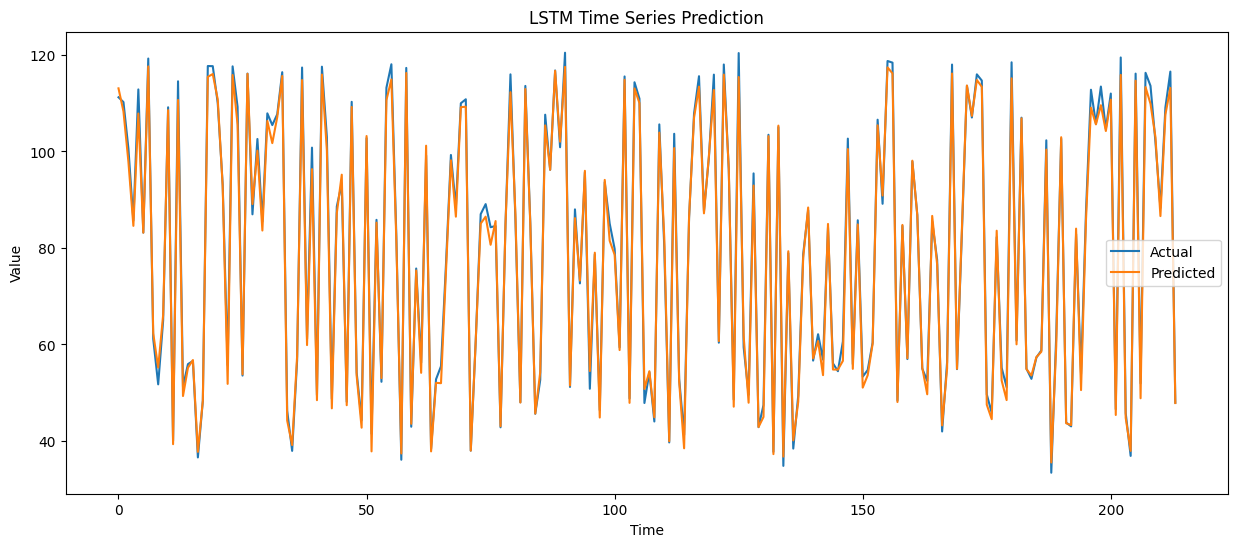

Model saved successfully.
Model loaded successfully.


/tmp/ipykernel_3341773/571783993.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('lstm_model.pth'))


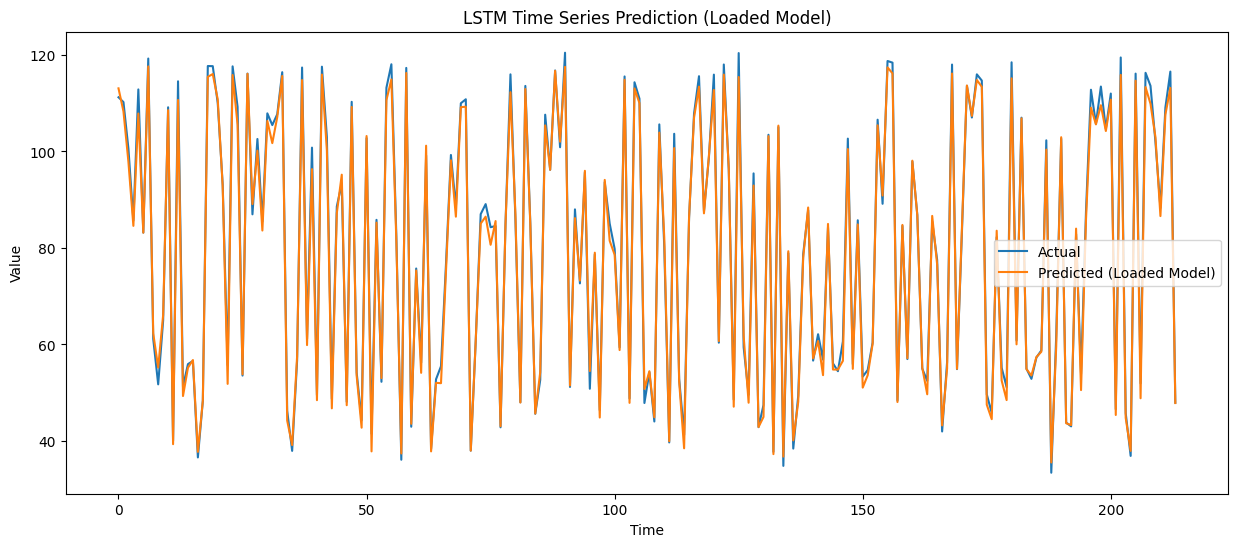

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 시드 설정
torch.manual_seed(0)
np.random.seed(0)

# 샘플 데이터 생성 (실제 사용 시 이 부분을 실제 데이터로 대체하세요)
dates = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
data = np.random.randn(len(dates)).cumsum() + 100
df = pd.DataFrame({'date': dates, 'value': data})

# 데이터 전처리
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))

# 시퀀스 데이터셋 클래스
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length], 
                self.data[idx+self.seq_length])

# LSTM 모델 클래스
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 하이퍼파라미터 설정
seq_length = 30
hidden_size = 50
num_layers = 1
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# 데이터셋 및 데이터로더 생성
dataset = TimeSeriesDataset(scaled_data, seq_length)
train_size = int(len(dataset) * 0.8)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 초기화
model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 함수
def train_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    return np.array(predictions), np.array(actuals)

# 모델 학습
train_model(model, train_loader, num_epochs)

# 모델 평가
predictions, actuals = evaluate_model(model, test_loader)

# 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(actuals), label='Actual')
plt.plot(scaler.inverse_transform(predictions), label='Predicted')
plt.legend()
plt.title('LSTM Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# 모델 저장
torch.save(model.state_dict(), 'lstm_model.pth')
print("Model saved successfully.")

# 모델 로드
loaded_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
loaded_model.load_state_dict(torch.load('lstm_model.pth'))
loaded_model.eval()
print("Model loaded successfully.")

# 로드된 모델로 예측
loaded_predictions, _ = evaluate_model(loaded_model, test_loader)

# 로드된 모델의 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(actuals), label='Actual')
plt.plot(scaler.inverse_transform(loaded_predictions), label='Predicted (Loaded Model)')
plt.legend()
plt.title('LSTM Time Series Prediction (Loaded Model)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()